In [1]:
import os
import sys
import pyro
import pandas as pd
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch

from torch import Tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

print(os.getcwd())
datapath = os.getcwd()+"/folds/synthetic_data2.csv"
# sys.path.append('../..')  # Adjust the path as needed

from src import SingleGP, MtlDeepGP, DeepGPNoBias, DeepGP

c:\Users\yuanq\Desktop\SB\SB\research\causality\code\MTL_DGP


In [2]:
torch.cuda.is_available()
# trouble shoot see this link:https://stackoverflow.com/questions/77068908/how-to-install-pytorch-with-cpu-support-on-windows-11-cpu-12-no-matching

False

In [3]:
# torch.cpu.current_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# cpu = torch.device('cpu') dd

In [4]:
torch.manual_seed(42)

In [6]:
# Load data from CSV
data = pd.read_csv(datapath)

# Separate the features (X) and outputs (Y1 and Y2)
X = data[['X']].values  # input features
Y1 = data['Y1'].values  # Task 1 output
Y2 = data['Y2'].values  # Task 2 output

from sklearn.model_selection import train_test_split

# Split into train and test for the inputs and both task outputs
X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X, Y1, Y2, test_size=0.3, random_state=42)

# Print the shapes of the train and test sets
print("Train X:", X_train.shape)
print("Test X:", X_test.shape)
print("Train Y1:", Y1_train.shape)
print("Test Y1:", Y1_test.shape)
print("Train Y2:", Y2_train.shape)
print("Test Y2:", Y2_test.shape)


Train X: (140, 1)
Test X: (60, 1)
Train Y1: (140,)
Test Y1: (60,)
Train Y2: (140,)
Test Y2: (60,)


In [7]:
x_train = torch.tensor( np.hstack([X_train, X_train]), dtype=torch.float32)
y_train = torch.tensor( np.vstack([Y1_train, Y2_train]), dtype=torch.float32).T
x_test = torch.tensor( np.hstack([X_test, X_test]) , dtype=torch.float32)
y_test = torch.tensor( np.vstack([Y1_test, Y2_test]), dtype=torch.float32).T

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([140, 2])
torch.Size([140, 2])
torch.Size([60, 2])
torch.Size([60, 2])


In [8]:
class Model(PyroModule):
    def __init__(self, dim_list=[1, 1, 1], J_list=[50, 10]):#in_dim=1, out_dim=1, J=50):
        super().__init__()

        out_dim = 2
        self.out_dim = out_dim
        self.model = MtlDeepGP()
        self.model.to('cpu')

    def forward(self, x, y=None):
        mu = self.model(x)#.squeeze() 
        
        scale = pyro.sample("sigma", dist.Gamma(torch.tensor(0.5, device='cpu'), torch.tensor(1.0, device='cpu'))).expand(self.out_dim)  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]): # x.shape[0]=10000
            # obs = xxx("obs", mu, obs=y)
            obs = pyro.sample("obs", dist.MultivariateNormal(mu.cpu(), torch.diag(scale * scale).cpu()), obs=y)
            
#         f1: phi(Omega x)W (+ epsilon1)
#         f2: phi(Omega f1)W (+ epsilon2)
        
#         f2 + epsilon ~ N(0, Sigma)
            
        return mu

In [9]:
class ModelDGP(PyroModule):
    def __init__(self, dim_list=[1,1,1], J_list=[50,10]):
        super().__init__()
        
        self.out_dim = dim_list[-1]
        self.model = DeepGP(dim_list, J_list)
        self.model.to('cpu')

    def forward(self, x, y=None):
        mu = self.model(x)#.squeeze() #10000*6
        
        # batch shape | event shapt
        # 10000       |
        #scale = torch.FloatTensor([1e-8]*self.out_dim).cuda()
        scale = pyro.sample("sigma", dist.Gamma(torch.tensor(0.5), torch.tensor(1.0))).expand(self.out_dim)  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]): # x.shape[0]=10000
            # obs = xxx("obs", mu, obs=y)
            obs = pyro.sample("obs", dist.MultivariateNormal(mu, torch.diag(scale * scale)), obs=y)


            
#         f1: phi(Omega x)W (+ epsilon1)
#         f2: phi(Omega f1)W (+ epsilon2)
        
#         f2 + epsilon ~ N(0, Sigma)
            
        return mu

In [10]:
# model = Model(in_dim=x_train.shape[1], out_dim=y_train.shape[1], J=5)
# model = ModelDGP()
model = Model()
model = model.to('cpu')

[SingleGPNoBias(
  (layers): PyroModuleList(
    (0): FirstLayer(
      (layer): PyroLinear(in_features=1, out_features=10, bias=False)
    )
    (1): SecondLayerNoBias(
      (layer): PyroLinear(in_features=20, out_features=1, bias=False)
    )
  )
)]
[SingleGPNoBias(
  (layers): PyroModuleList(
    (0): FirstLayer(
      (layer): PyroLinear(in_features=1, out_features=10, bias=False)
    )
    (1): SecondLayerNoBias(
      (layer): PyroLinear(in_features=20, out_features=1, bias=False)
    )
  )
)]
[SingleGPNoBias(
  (layers): PyroModuleList(
    (0): FirstLayer(
      (layer): PyroLinear(in_features=1, out_features=10, bias=False)
    )
    (1): SecondLayerNoBias(
      (layer): PyroLinear(in_features=20, out_features=1, bias=False)
    )
  )
)]


In [33]:

mean_field_guide = AutoDiagonalNormal(model)
# optimizer = pyro.optim.Adam({"lr": 0.01})
beta1 = 0.9  # 一阶矩的指数衰减率
beta2 = 0.999  # 二阶矩的指数衰减率

# 初始化 Adam 优化器，传递 beta 参数
optimizer = pyro.optim.Adam({
    "lr": 0.01,  # 学习率
    "betas": (beta1, beta2)  # 自定义的 beta 参数
})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 5000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

In [34]:
# trace = pyro.poutine.trace(model).get_trace(data)
# print(trace.format_shapes())

In [35]:
model.parameters()

<generator object Module.parameters at 0x0000022E520BCE40>

In [36]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)

In [37]:
y_pred = preds['obs'].cpu().detach().numpy().mean(axis=0)

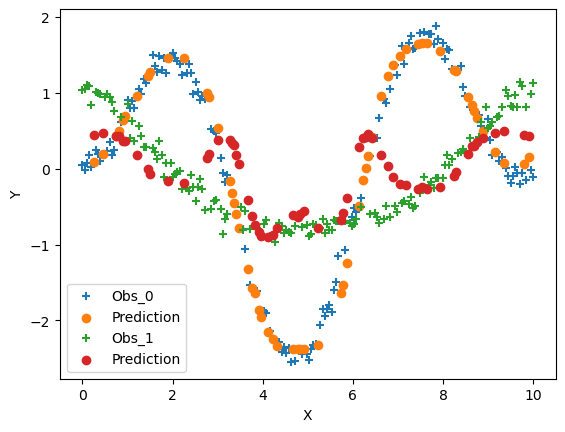

In [38]:
for d in range(2):
    plt.scatter(x_train[:,0].cpu(), y_train.cpu()[:,d], label=f"Obs_{d}", marker='+')
    plt.scatter(x_test[:,0].cpu(), y_pred[:,d], label="Prediction", marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [39]:

print(model)

Model(
  (model): MtlDeepGP(
    (GPcommon): DeepGPNoBias(
      (layers): PyroModuleList(
        (0): SingleGPNoBias(
          (layers): PyroModuleList(
            (0): FirstLayer(
              (layer): PyroLinear(in_features=1, out_features=10, bias=False)
            )
            (1): SecondLayerNoBias(
              (layer): PyroLinear(in_features=20, out_features=1, bias=False)
            )
          )
        )
      )
    )
    (GP1): DeepGPNoBias(
      (layers): PyroModuleList(
        (0): SingleGPNoBias(
          (layers): PyroModuleList(
            (0): FirstLayer(
              (layer): PyroLinear(in_features=1, out_features=10, bias=False)
            )
            (1): SecondLayerNoBias(
              (layer): PyroLinear(in_features=20, out_features=1, bias=False)
            )
          )
        )
      )
    )
    (GP2): DeepGPNoBias(
      (layers): PyroModuleList(
        (0): SingleGPNoBias(
          (layers): PyroModuleList(
            (0): FirstLayer(
 

In [40]:
result = model(x_train)
z = model.model.z
print(z.shape)

torch.Size([140, 1])


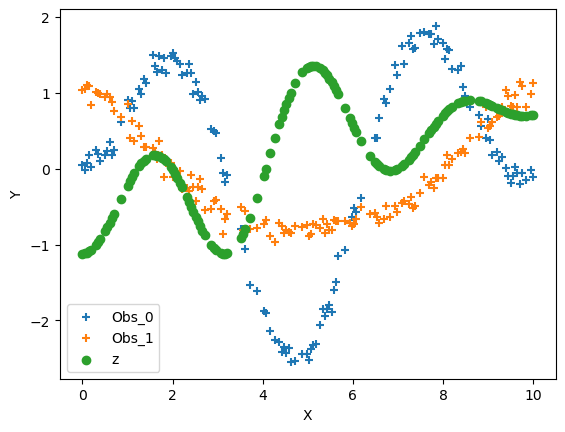

In [41]:

for d in range(2):
    plt.scatter(x_train[:,0].cpu(), y_train.cpu()[:,d], label=f"Obs_{d}", marker='+')
    # plt.scatter(x_train[:,0].cpu(), y_pred[:,d], label="Prediction", marker='o')
plt.scatter(x_train[:,0].cpu(), z[:,0].cpu(), label=f"z", marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()